In [9]:
# Load the feature sim from the checkpoint
import torch
# format is checkpoints/feature_sim_0.pt, checkpoints/feature_sim_19, checkpoints/feature_sim_39
# checkpoint_every = 30
# max_checkpoint = 420
checkpoint_every = 50
max_checkpoint = 600
# checkpoint_every = 10
# max_checkpoint = 60

# all_checkpoint_names = [f"checkpoints/feature_sim_{i}.pt" for i in list(range(19, 360, 20))]
all_checkpoint_names = [f"checkpoints/feature_sim_{i}.pt" for i in list(range(checkpoint_every, max_checkpoint, checkpoint_every))]

all_acts = []
all_ce_diffs = []
noisy_ce_diff = None
noisy_acts = None
for checkpoint_name in all_checkpoint_names:
    checkpoint_noise = torch.load(checkpoint_name)
    ce_diff_key, activation_key, orig_feat_key, noisy_feat_key  = checkpoint_noise.keys()
    # just get original activation & ce diff
    if checkpoint_name == all_checkpoint_names[5]:
        noisy_ce_diff = checkpoint_noise[ce_diff_key]
        noisy_acts = checkpoint_noise[activation_key]
    activations = checkpoint_noise[activation_key]
    ce_diffs = checkpoint_noise[ce_diff_key]
    all_acts.append(activations)
    all_ce_diffs.append(ce_diffs)

all_acts = torch.cat(all_acts, dim=0)
all_ce_diffs = torch.cat(all_ce_diffs, dim=0)


tensor(-0., dtype=torch.float16)
tensor(-0., dtype=torch.float16)
tensor(-0., dtype=torch.float16)
tensor(-0., dtype=torch.float16)
tensor(1.1921e-07, dtype=torch.float16)
tensor(-0., dtype=torch.float16)
tensor(-0., dtype=torch.float16)
tensor(-0., dtype=torch.float16)
tensor(-0., dtype=torch.float16)
tensor(-0., dtype=torch.float16)
tensor(-0., dtype=torch.float16)


In [12]:
original_name = "checkpoints/first_batch_info_skip_first_token.pt"
first_checkpoint = torch.load(original_name)
ce_key, act_key, tok_key = first_checkpoint.keys()
orig_ce_loss = first_checkpoint[ce_key]

In [14]:
orig_ce_loss.shape, noisy_ce_diff.shape

(torch.Size([640, 127]), torch.Size([640, 127]))

In [38]:
EPS = 1e-3 # Any lower & we get infs. past 1e-8, we get nans
log_odds = torch.log((noisy_ce_diff + EPS)/(orig_ce_loss + EPS))
print(f"Num of Nans: ", log_odds.isnan().sum().item())
print(f"Num of infs: ", log_odds.isinf().sum().item())
# orig_ce_loss[], noisy_ce_diff[log_odds.isinf()]

Num of Nans:  0
Num of infs:  11


In [37]:
log_odds.min(), log_odds.max()

(tensor(-9.5703, dtype=torch.float16), tensor(9.5469, dtype=torch.float16))

In [41]:
log_odds.shape

torch.Size([640, 127])

In [43]:
log_odds.flatten()

tensor([nan, nan, nan,  ..., nan, nan, nan], dtype=torch.float16)

In [2]:
(all_acts.numel()*2)/(1024**3), all_ce_diffs.numel()*2/1024**3

(0.001665353775024414, 0.9592437744140625)

In [7]:
flat_ce = all_ce_diffs.flatten()
max_ce = flat_ce.max()
min_ce = flat_ce.min()
print(max_ce, min_ce)

tensor(367., dtype=torch.float16) tensor(-161.3750, dtype=torch.float16)


In [ ]:
noisy_ce_diff = 

In [4]:
# Max noise of CE dif -.07 is batch 300 (index 5)
all_checkpoint_names[5]

'checkpoints/feature_sim_300.pt'

In [4]:
# Let's figure out dead features
num_acts_threshold = 10
nz_mask = (noise_orig_feat !=0).sum(dim=(0,1)) > num_acts_threshold

In [5]:
nz_features = nz_mask.nonzero()[:, 0]

In [6]:
# import numpy as np
# import matplotlib.pyplot as plt
# for i in range(5):
#     o_d1 = noise_orig_feat[:, :, i]
#     n_d1 = noise_noisy_feat[:, :, i]
#     mask = o_d1 != 0
#     diff = o_d1[mask] - n_d1[mask]
#     # print the mean and std of the diff
#     print(f"Feature {i}: Mean = {diff.mean()}, Std = {diff.std()}")

#     plt.hist(diff, bins=25, label=f"Diff Feature {i}", alpha=0.5)
# plt.legend()
# plt.title("Feature Activation Difference")
# plt.show()

In [7]:


num_features = noise_orig_feat.shape[-1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
stds = []
vars = []
means = []
medians = []
for i in tqdm(nz_features):
# for i in tqdm(range(10)):
    o_d1 = noise_orig_feat[:, :, i]
    n_d1 = noise_noisy_feat[:, :, i]
    mask = o_d1 != 0
    diff = o_d1[mask].to(device) - n_d1[mask].to(device)
    stds.append(diff.std().item())
    vars.append(diff.var().item())
    means.append(diff.mean().item())
    medians.append(diff.median().item())

  0%|          | 0/7427 [00:00<?, ?it/s]

100%|██████████| 7427/7427 [02:10<00:00, 57.01it/s] 


In [8]:
def z_score_transform(x):
    return (x - x.mean()) / x.std()
stds = z_score_transform(torch.tensor(stds))
vars = z_score_transform(torch.tensor(vars))
means = z_score_transform(torch.tensor(means))
medians = z_score_transform(torch.tensor(medians))


In [9]:
stds.std(), stds.mean()

(tensor(1.), tensor(1.2719e-07))

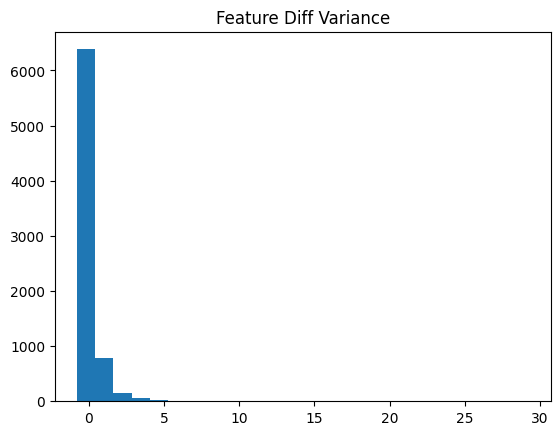

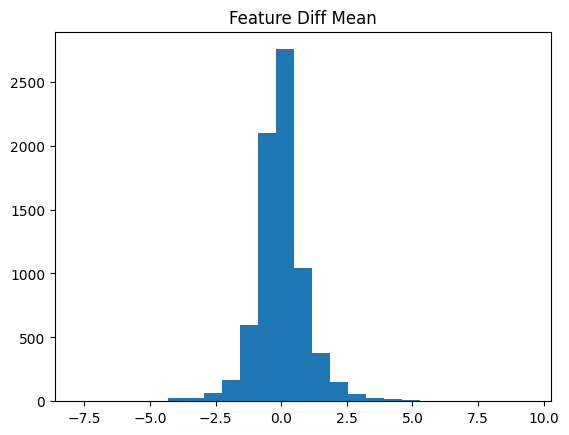

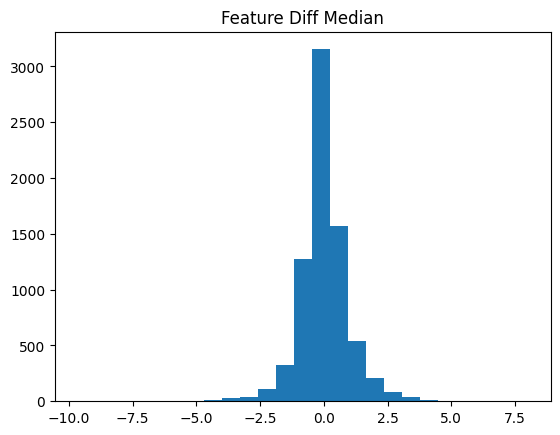

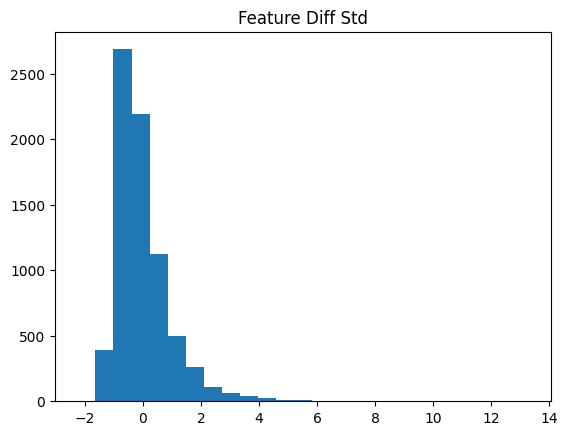

In [12]:
# plot a hist of the vars
from matplotlib import pyplot as plt
plt.hist(vars, bins=25, label="Variance")
plt.title("Feature Diff Variance")
plt.show()
# plot a hist of the means
plt.hist(means, bins=25, label="Mean")
plt.title("Feature Diff Mean")
plt.show()
# plot a hist of the medians
plt.hist(medians, bins=25, label="Median")
plt.title("Feature Diff Median")
plt.show()
# plot a hist of the stds
plt.hist(stds, bins=25, label="Std")
plt.title("Feature Diff Std")
plt.show()

In [11]:
mean_mags, mean_idxs = means.topk(10)
vars_mags, vars_idxs = vars.topk(10)
stds_mags, stds_idxs = stds.topk(10)
medians_mags, medians_idxs = medians.topk(10)

# Need to convert back to global indices through nz_features
print(f"Top 10 features by mean: {nz_features[mean_idxs]}")
print(f"Top 10 features by variance: {nz_features[vars_idxs]}")
print(f"Top 10 features by std: {nz_features[stds_idxs]}")
print(f"Top 10 features by median: {nz_features[medians_idxs]}")

# Now find the ones that have the near-zero stds
zero_vars = (vars < 0.0001).nonzero()[:, 0]
print(f"Top 10 features by zero var: {nz_features[zero_vars][30:50]}")

Top 10 features by mean: tensor([4239, 8481, 8604, 9187, 8494, 4305, 3551, 5336, 7991, 1464])
Top 10 features by variance: tensor([8649, 8442, 7747, 6814, 6759, 7933, 3596, 7656, 6382, 4305])
Top 10 features by std: tensor([8649, 8442, 7747, 6814, 6759, 7933, 3596, 7656, 6382, 4305])
Top 10 features by median: tensor([4239, 1464, 8481, 9187, 1462, 8604, 3551, 8494, 7991, 7255])
Top 10 features by zero var: tensor([59, 60, 61, 64, 65, 67, 68, 69, 71, 72, 73, 76, 79, 80, 82, 83, 85, 87,
        88, 90])


In [34]:
nz_features.shape, zero_vars.shape

(torch.Size([7427]), torch.Size([5240]))

In [9]:
n_d1.topk(10), o_d1.topk(10)
mask = o_d1 != 0
(o_d1[mask] - n_d1[mask])

tensor([-0.0706,  0.0834,  0.0460, -0.0913, -0.1450,  0.0207,  0.0056, -0.0278,
        -0.0132,  0.0049,  0.0286,  0.0780, -0.0527,  0.0186,  0.0154,  0.1267,
         0.2539, -0.0619, -0.0085,  0.3252, -0.0613,  0.1151,  0.0471,  0.0950,
        -0.0645], dtype=torch.float16)

In [31]:
num_acts_threshold = 10
noise_orig_feat_nz = noise_orig_feat[(noise_orig_feat !=0).sum(dim=(0,1)) > num_acts_threshold]

IndexError: The shape of the mask [9216] at index 0 does not match the shape of the indexed tensor [1600, 127, 9216] at index 0

In [34]:
noise_orig_feat

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [12]:
diff.topk(10)

torch.return_types.topk(
values=tensor([0.5693, 0.5493, 0.5137, 0.4055, 0.4016, 0.3955, 0.3914, 0.3826, 0.3652,
        0.3564], dtype=torch.float16),
indices=tensor([2471,  966, 1299, 2621, 2673, 1113, 2431, 2053,  915, 1161]))